# Regression

## Why regression?

- Model parameters.
- Forecasting.
- Filling missing data.


## How?

- Traditional approach:
  - Models:
    - AR
    - ARMA
    - ARIMA
    - SARIMA
    - SARIMAX
    - ...
  - Issues.
- Data mining-drived:
  - Models: *many*
  - Example today: Random Forest.
 

## Traditional approach

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

%run -i settings.py

In [2]:
# Load the data
df = pd.read_csv('data/london-2018.csv',
                 index_col=0, parse_dates=True)
df

drybulb  relhum  glohorrad  rainfall  windspd  winddir
2018-01-01 01:00:00     6.28   90.50        0.0  0.122079    10.25   266.82
2018-01-01 02:00:00     5.79   88.63        0.0  0.013495    10.55   271.34
2018-01-01 03:00:00     5.10   89.76        0.0  0.000444     8.96   260.11
2018-01-01 04:00:00     4.79   91.80        0.0  0.000199     8.02   242.19
2018-01-01 05:00:00     4.84   92.40        0.0  0.000625     7.74   228.02
...                      ...     ...        ...       ...      ...      ...
2018-12-31 20:00:00     7.26   91.93        0.0  0.015533     3.80   276.39
2018-12-31 21:00:00     7.17   92.34        0.0  0.011580     3.78   277.80
2018-12-31 22:00:00     7.06   92.71        0.0  0.009077     3.85   278.38
2018-12-31 23:00:00     6.71   93.86        0.0  0.012057     3.84   279.12
2019-01-01 00:00:00     6.71   93.03        0.0  0.019290     4.32   282.21

[8760 rows x 6 columns]

## Traditional approach

* Assumptions:
  - Normality.
  - Mean about 0.
  - Heteroskedasticity.
  - Independence: little correlation.
* Do these assumptions sound familiar?


ARIMA: Totally explainable statistical model for time series
Combines a series of auto-regressive coefficients with coefficients related to how errors behave in the past.

Let's check autocorrelation.

In [3]:
def diff(s: pd.Series, n: int=1) -> pd.Series:
    """Compute n-th discrete difference of element."""
    out = s.copy()
    for i in range(n):
        out = out.diff()
    return out

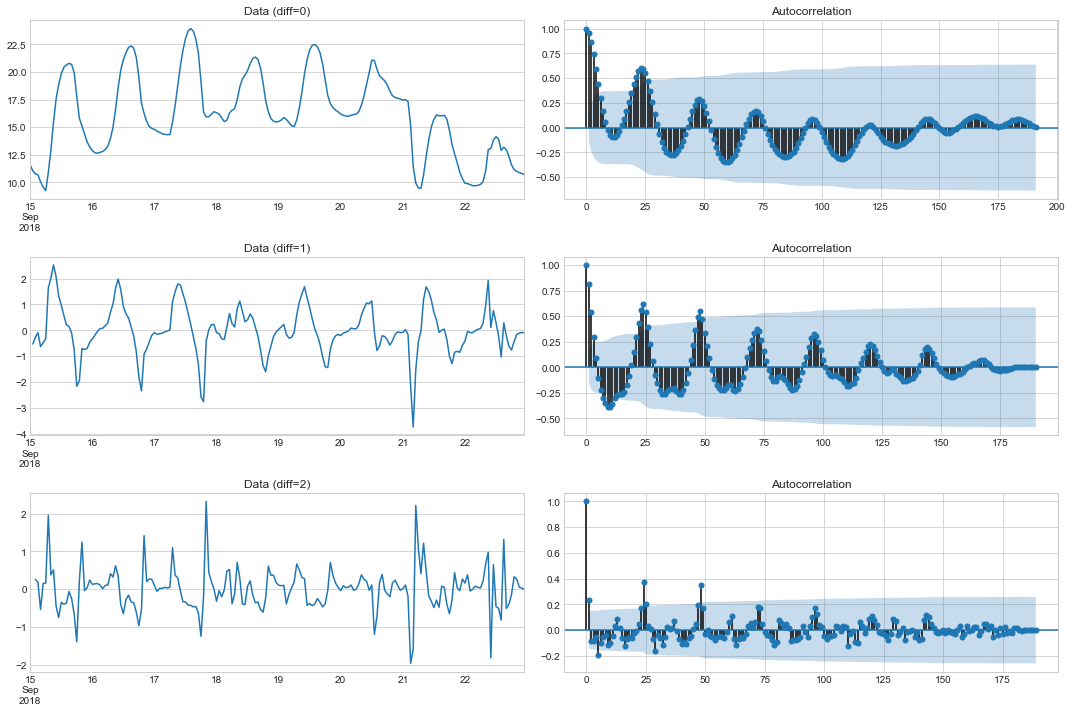

In [4]:
def row_acf(ax_row_, s, n_diff=0):
    s_diff = diff(s, n=n_diff)
    
    s_diff.plot(ax=ax_row_[0], title=f'Data (diff={n_diff})')
    plot_acf(s_diff.dropna(), ax=ax_row_[1])
    
    return ax_row_


# Say we want to model a week of the data
s = df.loc['2018-09-15':'2018-09-22', 'drybulb'].copy()

# Let us study the first three differentials
# (0: original data, 1: first, 2: second)
n_diff = 3
fig, axes = plt.subplots(figsize=(15, 10), sharex=False,
                         ncols=2, nrows=n_diff)

for i, ax_row in enumerate(axes):
    row_acf(ax_row_=ax_row, s=s, n_diff=i)

plt.tight_layout()
plt.show()

## Regression with Random forests

Let's ask a simple question: can future temperatures be predicted by the previous?

What exactly do we mean by previous values?

* Lagged values: past values.
* Expected seasonality: exploratory data analysis of particular use:
* Other information of any use where relevant:
  * Day of the year?
  * Day of the week? (Mon-Fri, Sat-Sun).


Random forests: learning from examples.

### Data wrangling

* Simple model:
  * Choose variable to be predicted.
  * Generate predictors based on expected behaviour.
  * Split into training and validation data.

In [5]:
col_predict = ['drybulb']
col_explain = ['t_01', 't_06', 't_24']

df_prep = (df[col_predict]
           .assign(t_01=lambda x: x[col_predict].shift( 1))
           .assign(t_06=lambda x: x[col_predict].shift( 6))
           .assign(t_24=lambda x: x[col_predict].shift(24))
           [col_predict + col_explain]
           .fillna(0)  # Not ideal, but just an example
          )
df_prep

drybulb  t_01  t_06  t_24
2018-01-01 01:00:00     6.28  0.00  0.00  0.00
2018-01-01 02:00:00     5.79  6.28  0.00  0.00
2018-01-01 03:00:00     5.10  5.79  0.00  0.00
2018-01-01 04:00:00     4.79  5.10  0.00  0.00
2018-01-01 05:00:00     4.84  4.79  0.00  0.00
...                      ...   ...   ...   ...
2018-12-31 20:00:00     7.26  7.27  9.05  5.55
2018-12-31 21:00:00     7.17  7.26  8.39  5.65
2018-12-31 22:00:00     7.06  7.17  7.10  5.86
2018-12-31 23:00:00     6.71  7.06  6.86  5.95
2019-01-01 00:00:00     6.71  6.71  7.15  5.91

[8760 rows x 4 columns]

In [6]:
# Split the data betweein training and tests datasets

# - Rule of thumb
ratio = 0.70
idx_break = int(len(df_prep) * ratio)

# - Notice time order: the past predicts the future!
X_train = df_prep.iloc[:idx_break][col_explain]
y_train = df_prep.iloc[:idx_break][col_predict]
X_test  = df_prep.iloc[idx_break:][col_explain]
y_test  = df_prep.iloc[idx_break:][col_predict]

In [7]:
X_train

t_01  t_06   t_24
2018-01-01 01:00:00   0.00  0.00   0.00
2018-01-01 02:00:00   6.28  0.00   0.00
2018-01-01 03:00:00   5.79  0.00   0.00
2018-01-01 04:00:00   5.10  0.00   0.00
2018-01-01 05:00:00   4.79  0.00   0.00
...                    ...   ...    ...
2018-09-13 08:00:00   8.75  8.24  12.80
2018-09-13 09:00:00  11.00  7.66  13.67
2018-09-13 10:00:00  14.09  7.26  15.02
2018-09-13 11:00:00  16.68  6.97  16.05
2018-09-13 12:00:00  17.82  6.74  16.36

[6132 rows x 3 columns]

In [8]:
y_train

drybulb
2018-01-01 01:00:00     6.28
2018-01-01 02:00:00     5.79
2018-01-01 03:00:00     5.10
2018-01-01 04:00:00     4.79
2018-01-01 05:00:00     4.84
...                      ...
2018-09-13 08:00:00    11.00
2018-09-13 09:00:00    14.09
2018-09-13 10:00:00    16.68
2018-09-13 11:00:00    17.82
2018-09-13 12:00:00    18.75

[6132 rows x 1 columns]

### Build the model

The scikit-learn way.

In [9]:
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestRegressor

In [10]:
# Build model
args_model = {
    "n_estimators": 500,
    "criterion": 'mse',
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_features": None,
    "max_leaf_nodes": None,
    "min_impurity_decrease": 0.,
    "bootstrap": True,
    "oob_score": True,
    "n_jobs": -1,
    "random_state": check_random_state(1234),  # Not really random :)
    "verbose": 1,
    "warm_start": False,
}
model = RandomForestRegressor(**args_model)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True,
           random_state=<mtrand.RandomState object at 0x0000020006E1D438>,
           verbose=1, warm_start=False)

### Train the model

In [11]:
model.fit(X_train.values, y_train.values)

settings.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Pandas
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True,
           random_state=<mtrand.RandomState object at 0x0000020006E1D438>,
           verbose=1, warm_start=False)

### Predict observations

In [12]:
y_model = model.predict(df_prep[col_explain])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


### Evaluate

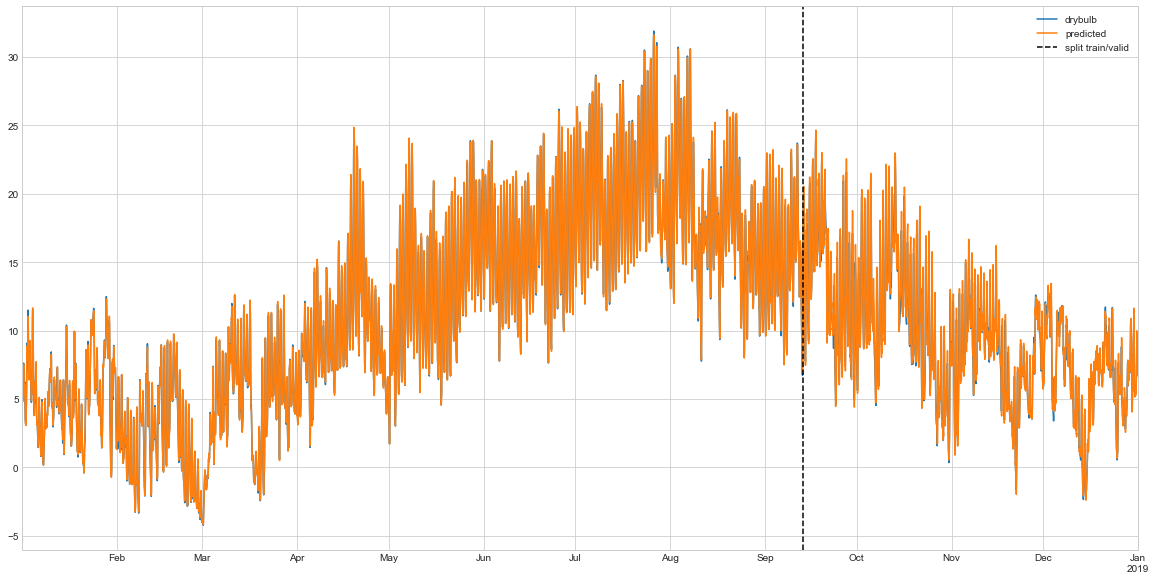

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
df_prep[col_predict].plot(ax=ax, label='observed')
pd.Series(y_model, df_prep.index).plot(ax=ax, label='predicted')
ax.axvline(x=df_prep.iloc[idx_break, :].name, color='black', ls='--', label='split train/valid')
plt.legend()
plt.show()

### Under the hood

* Predictions of many individual trees.
* Ensemble: stronger together.

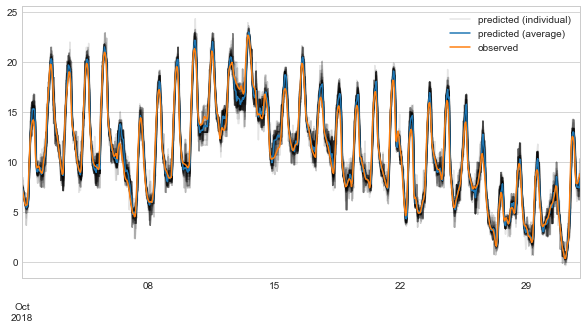

In [14]:
# Make predictions with each invidiual tree
y_trees = {}
for i, tree in enumerate(model.estimators_):
    y_trees[i] = tree.predict(df_prep[col_explain])

# Prepare data (take a small random sample to visualize)
n_sample = 40
cols = np.random.randint(0, len(y_trees), size=n_sample)
data = pd.DataFrame(y_trees, df_prep.index)
dates = '2018-10'

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
data[dates].iloc[:, cols].plot(ax=ax, color='black', alpha=0.1)
data[dates].iloc[:,  0  ].plot(ax=ax, color='black', alpha=0.1, label='predicted (individual)')
data[dates].mean(axis=1 ).plot(ax=ax, alpha=1.0, label='predicted (average)')
df_prep.loc[dates, 'drybulb'].plot(ax=ax, label='observed')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[-3:], labels[-3:])

plt.show()

### Distances

Compute distances to appraise the goodness of fit during the validation period.

In [15]:
print(f'R^2: {model.score(X_test, y_test):.5f}')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


R^2: 0.97118


### Variable importance

What predictors where more influential?

In [16]:
importances = model.feature_importances_
values = [tree.feature_importances_ for tree in model.estimators_]
indices = np.argsort(importances)[::-1]

# Create table
df_importance = (pd.DataFrame(data={'name': df_prep[col_explain].columns[indices],
                                    'avg':  importances[indices],
                                    'std':  np.std(values, axis=0)[indices],
                                   })
                 .loc[:, ['name', 'avg', 'std']]
                )

df_importance

name       avg       std
0  t_01  0.986750  0.000443
1  t_06  0.009303  0.000372
2  t_24  0.003946  0.000282

## Activities

## References

1. Box, G.E.P., Jenkins, G.M. & Reinsel, G.C., 2016. Time Series Analysis - Forecasting and Control 5th ed.
1. Faraway, J.J., 2016. Extending the linear model with R: generalized linear, mixed effects and nonparametric regression models, CRC press.
1. Hastie, T., Tibshirani, R. & Friedman, J., 2009. The Elements of Statistical Learning 2nd ed., New York: Springer New York.
1. Shumway, R.H. & Stoffer, D.S., 2017. Time Series Analysis and Its Applications, Cham: Springer International Publishing.